In [60]:
import torch
import torch.nn as nn
import snntorch as snn
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [17]:
batch_size = 128
data_path='/data/mnist'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 10799469.49it/s]


Extracting /data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to /data/mnist\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 9816506.79it/s]

Extracting /data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to /data/mnist\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 9856428.79it/s]


Extracting /data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to /data/mnist\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2275505.11it/s]

Extracting /data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to /data/mnist\MNIST\raw



In [19]:
from snntorch import surrogate

beta = 0.9  # neuron decay rate
spike_grad = surrogate.fast_sigmoid() # fast sigmoid surrogate gradient

#  Initialize Convolutional SNN
net = nn.Sequential(nn.Conv2d(1, 8, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(8, 16, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(16*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [22]:
import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [43]:
import torch.nn.functional as F

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        num_inputs = 784 # number of inputs
        num_hidden = 300 # number of hidden neurons
        num_outputs = 10 # number of classes (i.e., output neurons)

        beta1 = 0.9 # global decay rate for all leaky neurons in layer 1
        beta2 = torch.rand((num_outputs), dtype = torch.float) # independent decay rate for each leaky neuron in layer 2: [0, 1)

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta1) # not a learnable decay rate
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta2, learn_beta=True) # learnable decay rate

    def forward(self, x):
        mem1 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem2 = self.lif2.init_leaky() # reset/init hidden states at t=0
        spk2_rec = [] # record output spikes
        mem2_rec = [] # record output hidden states

        for step in range(num_steps): # loop over time
            cur1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2) # record spikes
            mem2_rec.append(mem2) # record membrane

        return torch.stack(spk2_rec), torch.stack(mem2_rec)

# Load the network onto CUDA if available
net = Net().to(device)

In [44]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

num_epochs = 1 # run for 1 epoch - each data sample is seen only once
num_steps = 25  # run for 25 time steps

loss_hist = [] # record loss over iterations
acc_hist = [] # record accuracy over iterations

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, _ = net(data) # forward-pass
        loss_val = loss_fn(spk_rec, targets) # loss calculation
        optimizer.zero_grad() # null gradients
        loss_val.backward() # calculate gradients
        optimizer.step() # update weights
        loss_hist.append(loss_val.item()) # store loss

        # print every 25 iterations
        if i % 25 == 0:
          net.eval()
          print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

          # check accuracy on a single batch
          acc = SF.accuracy_rate(spk_rec, targets)
          acc_hist.append(acc)
          print(f"Accuracy: {acc * 100:.2f}%\n")

        # uncomment for faster termination
        # if i == 150:
        #     break

Epoch 0, Iteration 0 
Train Loss: 2.48
Accuracy: 16.41%

Epoch 0, Iteration 25 
Train Loss: 0.62
Accuracy: 72.66%

Epoch 0, Iteration 50 
Train Loss: 0.40
Accuracy: 80.47%

Epoch 0, Iteration 75 
Train Loss: 0.25
Accuracy: 95.31%

Epoch 0, Iteration 100 
Train Loss: 0.23
Accuracy: 93.75%

Epoch 0, Iteration 125 
Train Loss: 0.22
Accuracy: 89.84%

Epoch 0, Iteration 150 
Train Loss: 0.19
Accuracy: 93.75%

Epoch 0, Iteration 175 
Train Loss: 0.19
Accuracy: 92.97%

Epoch 0, Iteration 200 
Train Loss: 0.15
Accuracy: 96.09%

Epoch 0, Iteration 225 
Train Loss: 0.16
Accuracy: 96.09%

Epoch 0, Iteration 250 
Train Loss: 0.13
Accuracy: 95.31%

Epoch 0, Iteration 275 
Train Loss: 0.13
Accuracy: 95.31%

Epoch 0, Iteration 300 
Train Loss: 0.17
Accuracy: 92.19%

Epoch 0, Iteration 325 
Train Loss: 0.14
Accuracy: 96.88%

Epoch 0, Iteration 350 
Train Loss: 0.14
Accuracy: 95.31%

Epoch 0, Iteration 375 
Train Loss: 0.13
Accuracy: 95.31%

Epoch 0, Iteration 400 
Train Loss: 0.12
Accuracy: 95.31%

Ep

In [62]:
spk_rec.shape
np.where(spk_rec.detach().numpy())

(array([ 0,  0,  1, ..., 24, 24, 24], dtype=int64),
 array([62, 71,  0, ..., 95, 95, 95], dtype=int64),
 array([7, 7, 9, ..., 3, 7, 9], dtype=int64))

In [66]:
temp = spk_rec[:,0,:]

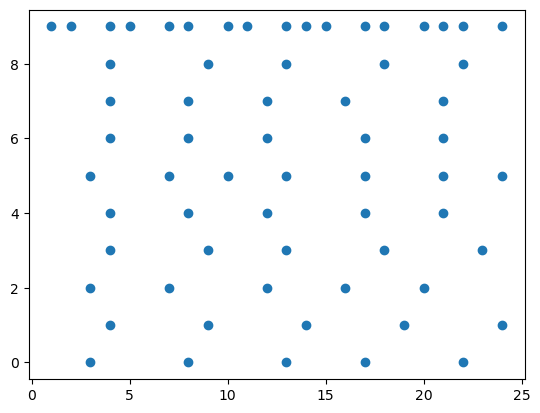

In [71]:
plt.figure()
plt.scatter(np.where(temp.detach().numpy())[0], np.where(temp.detach().numpy())[1],alpha=1)
plt.show()

In [51]:
data, targets = next(enumerate(train_loader))
targets[0].shape,targets[1].shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [45]:
print(f"Trained decay rate of the first layer: {net.lif1.beta:.3f}\n")

print(f"Trained decay rates of the second layer: {net.lif2.beta}")

Trained decay rate of the first layer: 0.900

Trained decay rates of the second layer: Parameter containing:
tensor([0.3060, 0.3592, 0.7304, 0.8296, 0.8427, 0.5422, 0.5867, 0.4185, 0.9465,
        0.5542], requires_grad=True)


In [47]:
net.mem2_rec

AttributeError: 'Net' object has no attribute 'mem2_rec'